In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pickle
from tqdm import tqdm
import rdflib
from rdflib import Graph
from rdflib.namespace import BRICK
import warnings

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
filename_ttl='datasets/bts_site_b_train/Site_B.ttl'

g = Graph().parse(filename_ttl)

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
p33f3e0c2_f2cd_471c_b5a0_4655c2bd4623:0d5d19dc_e106_4cfb_9bee_c5f6d46e4388 a brick:Building_Gas_Meter ;
    brick:feeds p33f3e0c2_f2cd_471c_b5a0_4655c2bd4623:1f182f96_a9a9_4f89_adfc_e8c11498e926 ;
    brick:hasLocation p33f3e0c2_f2cd_471c_b5a0_4655c2bd4623:13211186_beb4_4227_bd2d_0644e860886e .


p33f3e0c2_f2cd_471c_b5a0_4655c2bd4623:1ca047e2_b601_4ba7_a579_abcfa7a45ea7.7db45373_727c_4019_8f6d_c50cd077dfdb a brick:Usage_Sensor ;
    senaps:stream_id "a1be7214_6b91_4243_8dd5_df8e81591ffe" ;
    brick:isPointOf p33f3e0c2_f2cd_471c_b5a0_4655c2bd4623:0d5d19dc_e106_4cfb_9bee_c5f6d46e4388 .

Usage_Sensor is a point of Building_Gas_Meter

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



In [4]:
# Define the SPARQL query to retrieve Gas Meter sensors
query_gas = """
SELECT ?meter ?sensor ?stream_id
WHERE {
    ?sensor rdf:type brick:Usage_Sensor .
    ?meter rdf:type brick:Building_Gas_Meter .
    ?sensor brick:isPointOf ?meter .
    ?sensor senaps:stream_id ?stream_id
}
ORDER BY ?meter
"""

# Run the query
results_gas = g.query(query_gas)

# Prepare the data for the DataFrame
data_gas = []
for row in results_gas:
    data_gas.append({
        'Meter': str(row['meter']),
        'Sensor': str(row['sensor']),
        'Stream ID': str(row['stream_id'])
    })

# Create a DataFrame from the results
df_gas_meters = pd.DataFrame(data_gas)

In [5]:
# df_gas_meters.to_csv('./gas_usage_meter.csv') # to get to know the value in path

In [6]:
def load_sensors_from_db(df, db):
    """
    Load the sensor data corresponding to the stream IDs in the DataFrame using the DBManager instance.
    """
    # Ensure that both StreamID columns are strings
    df['Stream ID'] = df['Stream ID'].astype(str).str.lower()

    # Function to retrieve sensor data from the database for a given stream ID
    def get_sensor_data_for_stream(stream_id):
        if pd.isna(stream_id):  # Handle missing stream_id
            print(f"Stream ID is missing: {stream_id}")
            return None
        
        # Fetch the sensor data from the database using the provided stream ID
        try:
            sensor_df = db.get_stream(stream_id).dropna()
            if not sensor_df.empty:
                return {
                    'streamid': stream_id,
                    'sensor_type': sensor_df['label'].iloc[0],  # Assuming label is the sensor type
                    'timestamps': pd.to_datetime(sensor_df['time']),
                    'values': sensor_df['value']
                }
            else:
                print(f"No data found for Stream ID: {stream_id}")
                return None
        except Exception as e:
            print(f"Error loading data for Stream ID {stream_id}: {e}")
            return None

    # Apply the function to load sensor data for each stream ID
    df['sensor_data'] = df['Stream ID'].apply(get_sensor_data_for_stream)

    return df

In [7]:
from dbmanager import DBManager

data_zip_path = 'datasets/bts_site_b_train/train.zip'
# print(data_zip_path)
mapping_csv_path = 'datasets/bts_site_b_train/mapper_TrainOnly.csv'
db = DBManager(data_zip_path, mapping_csv_path)


In [8]:
# Test get_stream function
# df = db.get_stream('ffdb52d3_f6f9_4b2d_96f4_3b9e3ee0600a')
# display(df)

In [9]:
df_gas_meters_data = load_sensors_from_db(df_gas_meters, db)

In [10]:
df_gas_meters_data.head()

,Meter,Sensor,Stream ID,sensor_data
0,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,3624bd6d_337e_4b72_ba60_2233f1c1137f,{'streamid': '3624bd6d_337e_4b72_ba60_2233f1c1...
1,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,be6f602f_e7d7_4a46_ba50_7ef7fba0d76e,{'streamid': 'be6f602f_e7d7_4a46_ba50_7ef7fba0...
2,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,ffdb52d3_f6f9_4b2d_96f4_3b9e3ee0600a,{'streamid': 'ffdb52d3_f6f9_4b2d_96f4_3b9e3ee0...
3,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,4117d845_cd0d_4759_97b0_bd4ab87c595a,{'streamid': '4117d845_cd0d_4759_97b0_bd4ab87c...
4,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,894ffb99_daa6_4436_ab8f_4d95f7a8af5e,{'streamid': '894ffb99_daa6_4436_ab8f_4d95f7a8...


In [31]:
df_gas_meters_data['sensor_data'][0]

{'streamid': '3624bd6d_337e_4b72_ba60_2233f1c1137f',
 'sensor_type': 'Usage_Sensor',
 'timestamps': 0      2021-04-04 19:43:00
 1      2021-04-04 20:43:00
 2      2021-04-04 21:43:00
 3      2021-04-04 22:43:00
 4      2021-04-04 23:43:00
                ...        
 6101   2021-12-24 18:37:00
 6102   2021-12-24 19:37:00
 6103   2021-12-24 20:37:00
 6104   2021-12-24 21:37:00
 6105   2021-12-24 22:37:00
 Name: time, Length: 6106, dtype: datetime64[ns],
 'values': 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
        ... 
 6101    0.0
 6102    0.0
 6103    0.0
 6104    0.0
 6105    0.0
 Name: value, Length: 6106, dtype: float64}

In [32]:
df_gas_meters_data.shape[0]

6

In [12]:
gas_sensor_data = []
for i in range(df_gas_meters_data.shape[0]):
    gas_sensor_data.append(pd.DataFrame(df_gas_meters_data['sensor_data'][i]))

In [34]:
gas_sensor_data[1]

,streamid,sensor_type,timestamps,values
0,be6f602f_e7d7_4a46_ba50_7ef7fba0d76e,Usage_Sensor,2021-04-05 13:43:00,38807.5
1,be6f602f_e7d7_4a46_ba50_7ef7fba0d76e,Usage_Sensor,2021-04-06 13:43:00,38807.5
2,be6f602f_e7d7_4a46_ba50_7ef7fba0d76e,Usage_Sensor,2021-04-07 13:43:00,38807.5
3,be6f602f_e7d7_4a46_ba50_7ef7fba0d76e,Usage_Sensor,2021-04-08 13:43:00,38807.5
4,be6f602f_e7d7_4a46_ba50_7ef7fba0d76e,Usage_Sensor,2021-04-09 13:43:00,38807.5
...,...,...,...,...
251,be6f602f_e7d7_4a46_ba50_7ef7fba0d76e,Usage_Sensor,2021-12-20 12:37:00,56471.1
252,be6f602f_e7d7_4a46_ba50_7ef7fba0d76e,Usage_Sensor,2021-12-21 12:37:00,56471.1
253,be6f602f_e7d7_4a46_ba50_7ef7fba0d76e,Usage_Sensor,2021-12-22 12:37:00,56471.1
254,be6f602f_e7d7_4a46_ba50_7ef7fba0d76e,Usage_Sensor,2021-12-23 12:37:00,56471.1


(0.0, 30.0)

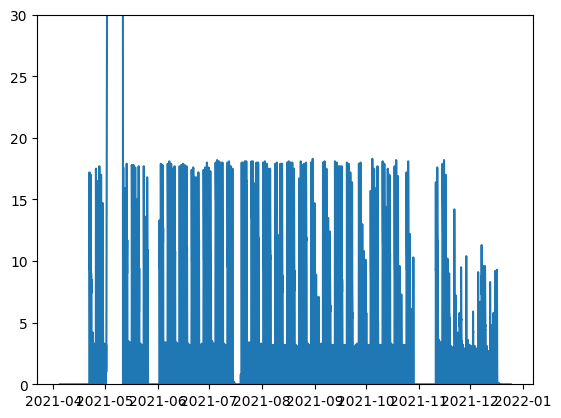

In [14]:
time_data = df_gas_meters_data['sensor_data'][0]['timestamps']
sensor_value_data = df_gas_meters_data['sensor_data'][0]['values']
plt.plot(time_data, sensor_value_data)
plt.ylim(0, 30)

### Outside air temp sensor (weather station)

In [15]:
filename_ttl='datasets/bts_site_b_train/Site_B.ttl'
g = Graph().parse(filename_ttl)
# Define the SPARQL query to retrieve Outside_Air_Temperature_Sensor
query_outside_airtemp = """
SELECT ?sensor ?stream_id 
WHERE {
    ?sensor rdf:type brick:Outside_Air_Temperature_Sensor .
    ?sensor brick:isPointOf   ?loc .
    ?loc a brick:Weather_Station .
    ?sensor senaps:stream_id ?stream_id .
}
ORDER BY ?stream_id
"""
# Run the query
results_outside_airtemp = g.query(query_outside_airtemp)
# Prepare the data for the DataFrame
data_outside_airtemp = []
for row in results_outside_airtemp:
    data_outside_airtemp.append({
        'Sensor': str(row['sensor']),
        'Stream ID': str(row['stream_id']),
    })
# Create a DataFrame from the results
df_outside_airtemp = pd.DataFrame(data_outside_airtemp)
# Display the DataFrame
display(df_outside_airtemp.head())

,Sensor,Stream ID
0,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,664ddc27_ccc5_43a1_97b7_3000c0e948db


In [16]:
df_outside_air_temp_data = load_sensors_from_db(df_outside_airtemp, db)
df_outside_air_temp_data

,Sensor,Stream ID,sensor_data
0,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,664ddc27_ccc5_43a1_97b7_3000c0e948db,{'streamid': '664ddc27_ccc5_43a1_97b7_3000c0e9...


In [17]:
df_outside_temperature = pd.DataFrame(df_outside_air_temp_data['sensor_data'][0])

In [18]:
df_outside_temperature.head()

,streamid,sensor_type,timestamps,values
0,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:03:11.512,26.250
1,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:13:40.218,26.765
2,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:23:11.538,27.585
3,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:33:11.510,28.300
4,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:43:11.600,28.820


#### Compute correlation

### Outside temperature

In [19]:
df_outside_temperature['timestamps'] = pd.to_datetime(df_outside_temperature['timestamps'])
daily_median_outside_temperature = df_outside_temperature.groupby(df_outside_temperature['timestamps'].dt.date)['values'].median().reset_index()
daily_median_outside_temperature.columns = ['date', 'outside_temp']
daily_median_outside_temperature.head()

,date,outside_temp
0,2021-01-01,24.940
1,2021-01-02,18.630
2,2021-01-03,17.620
3,2021-01-04,16.035
4,2021-01-05,16.505


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Function to compute rolling Spearman's Rank Correlation
def rolling_spearman(x, y, window):
    corr_values = []
    for i in range(len(x) - window + 1):
        # Compute Spearman's Rank Correlation for each rolling window
        corr, _ = spearmanr(x[i:i + window], y[i:i + window])
        # print(corr)
        corr_values.append(corr)
    # Pad with NaNs at the start to match the length of original data
    return np.concatenate((np.full(window - 1, np.nan), corr_values))

### Gas sensor data 

In [21]:
df_gas_sensor_data_1 = gas_sensor_data[1]
df_gas_sensor_data_1['timestamps'] = pd.to_datetime(df_gas_sensor_data_1['timestamps'])
daily_median_gas_sensor_data_1 = df_gas_sensor_data_1.groupby(df_gas_sensor_data_1['timestamps'].dt.date)['values'].median().reset_index()
daily_median_gas_sensor_data_1.columns = ['date', 'gas_sensor_val']
daily_median_gas_sensor_data_1.head()

,date,gas_sensor_val
0,2021-04-05,38807.5
1,2021-04-06,38807.5
2,2021-04-07,38807.5
3,2021-04-08,38807.5
4,2021-04-09,38807.5


In [22]:
daily_median_gas_sensor_data = []
for i in range(len(gas_sensor_data)):
    df_gas_sensor_data_1 = gas_sensor_data[i]
    df_gas_sensor_data_1['timestamps'] = pd.to_datetime(df_gas_sensor_data_1['timestamps'])
    daily_median_gas_sensor_data_1 = df_gas_sensor_data_1.groupby(df_gas_sensor_data_1['timestamps'].dt.date)['values'].median().reset_index()
    daily_median_gas_sensor_data_1.columns = ['date', 'gas_sensor_val']
    daily_median_gas_sensor_data.append(daily_median_gas_sensor_data_1)
    

In [23]:
df_gas_temperature = daily_median_gas_sensor_data[0].copy()
df_gas_temperature.columns = ['date', 'sensor1']
# Loop through the remaining dataframes and merge them
for i, df in enumerate(daily_median_gas_sensor_data[1:], start=2):
    df.columns = ['date', f'sensor{i}']
    df_gas_temperature = pd.merge(df_gas_temperature, df, on='date', how='outer')

In [24]:
df_gas_temperature

,date,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6
0,2021-01-01,NaN,NaN,531694.0,398124.0,0.0,133570.0
1,2021-01-02,NaN,NaN,531694.0,398124.0,0.0,133570.0
2,2021-01-03,NaN,NaN,531694.0,398124.0,0.0,133570.0
3,2021-01-04,NaN,NaN,531734.0,398124.0,0.0,133610.0
4,2021-01-05,NaN,NaN,531774.0,398124.0,0.0,133650.0
...,...,...,...,...,...,...,...
353,2021-12-20,0.0,56471.1,550554.0,398124.0,0.0,152430.0
354,2021-12-21,0.0,56471.1,550554.0,398124.0,0.0,152430.0
355,2021-12-22,0.0,56471.1,550554.0,398124.0,0.0,152430.0
356,2021-12-23,0.0,56471.1,550554.0,398124.0,0.0,152430.0


In [25]:
df_gas_outside_temperature = df_gas_temperature.merge(daily_median_outside_temperature, on='date', how='inner')
df_gas_outside_temperature['date'] = pd.to_datetime(df_gas_outside_temperature['date'])

In [26]:
df_gas_outside_temperature.dtypes

date            datetime64[ns]
sensor1                float64
sensor2                float64
sensor3                float64
sensor4                float64
sensor5                float64
sensor6                float64
outside_temp           float64
dtype: object

In [27]:
# df_gas_outside_temperature = df_gas_outside_temperature.dropna()

In [28]:
df_gas_outside_temperature.head()


,date,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,outside_temp
0,2021-01-01,NaN,NaN,531694.0,398124.0,0.0,133570.0,24.940
1,2021-01-02,NaN,NaN,531694.0,398124.0,0.0,133570.0,18.630
2,2021-01-03,NaN,NaN,531694.0,398124.0,0.0,133570.0,17.620
3,2021-01-04,NaN,NaN,531734.0,398124.0,0.0,133610.0,16.035
4,2021-01-05,NaN,NaN,531774.0,398124.0,0.0,133650.0,16.505


In [29]:
df = None

In [30]:
# Create the year_month column
df_gas_outside_temperature['year_month'] = df_gas_outside_temperature['date'].dt.to_period('M')

def calculate_monthly_correlation(dataframe, sensor_column):
    return dataframe.groupby('year_month').apply(
        lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
    )

sensor_columns = ['sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6']

# Dictionary to store results
monthly_correlations = {}

for sensor in sensor_columns:
    # Skip sensors with all NaN values
    if df_gas_outside_temperature[sensor].isna().all():
        # print(f"Skipping {sensor} as it contains all NaN values.")
        continue
    
    monthly_correlations[sensor] = calculate_monthly_correlation(df_gas_outside_temperature, sensor)

# Convert results to a dataframe
result_df = pd.DataFrame(monthly_correlations)

# Reset the index to make year_month a column
result_df = result_df.reset_index()
result_df['date'] = result_df['year_month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
for sensor in sensor_columns:
    if sensor in result_df.columns:
        plt.plot(result_df['date'], result_df[sensor], label=sensor)

plt.title('Monthly Sensor-Temperature Correlations')
plt.xlabel('Date')
plt.ylabel('Spearman Correlation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'stats' is not defined

In [ ]:
result_df = result_df.fillna(0)  ## Missing is set to 0

In [ ]:
result_df

In [ ]:
# Create the heatmap
sns.heatmap(result_df[['sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6']].T, 
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Correlation'},
            xticklabels=result_df['date'].dt.strftime('%Y-%m'),
            # yticklabels=['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6']
            yticklabels=[]
            )

# Customize the plot
plt.title('Gas Sensor Correlations with Outside Temperature', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sensors', fontsize=12)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Use tight layout to ensure all elements fit in the figure
plt.tight_layout()

In [ ]:
df = result_df

In [ ]:
result_df

In [ ]:
# GasAnalysis_WeatherSensitivity

In [ ]:
df.to_csv('GasAnalysis_WeatherSensitivity.csv', index=True)